In [0]:
%matplotlib inline
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import PIL

In [0]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

## Prob 3.2 Data Augmentation

In [26]:
train_transform = transforms.Compose(
    [
        transforms.ColorJitter(brightness=0.2, saturation=.05), # adding color jitter/noise
        
#         transforms.RandomVerticalFlip(),
        transforms.RandomHorizontalFlip(),              #random flipping
        transforms.RandomRotation(20, resample=PIL.Image.BILINEAR),                #randomly rotate
        # transforms.RandomAffine(0, (0.2,0.2)),        # randomly translate
        transforms.ToTensor(),
#         transforms.Lambda(lambda x : x + torch.randn_like(x)),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)


Files already downloaded and verified


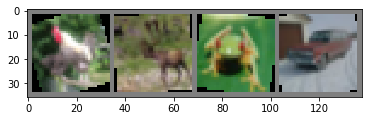

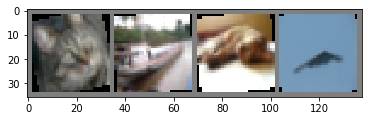

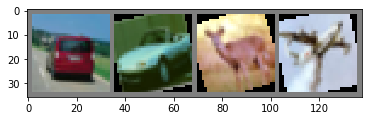

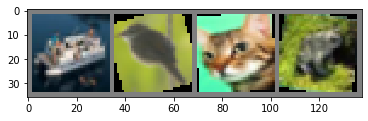

In [27]:
trainloader_view = torch.utils.data.DataLoader(trainset, batch_size=4,
                                            shuffle=True, num_workers=2)
dataiter = iter(trainloader_view)
for _ in range(4):
  
  images, labels = dataiter.next()
  imshow(torchvision.utils.make_grid(images))

In [28]:
test_transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=train_transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=test_transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


## Defining the LeNet architecture

In [0]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


net = Net()

In [0]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

## Training with augmented dataset

In [33]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
net = net.to(device)
for epoch in range(20):  # loop over the dataset multiple times

    running_loss = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if i % 200 == 199:    # print every 200 mini-batches
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / 200))
            running_loss = 0.0

print('Finished Training')

[1,   200] loss: 0.826
[1,   400] loss: 0.827
[1,   600] loss: 0.838
[1,   800] loss: 0.817
[1,  1000] loss: 0.827
[1,  1200] loss: 0.834
[1,  1400] loss: 0.828
[2,   200] loss: 0.836
[2,   400] loss: 0.835
[2,   600] loss: 0.812
[2,   800] loss: 0.836
[2,  1000] loss: 0.819
[2,  1200] loss: 0.813
[2,  1400] loss: 0.808
[3,   200] loss: 0.816
[3,   400] loss: 0.821
[3,   600] loss: 0.816
[3,   800] loss: 0.796
[3,  1000] loss: 0.842
[3,  1200] loss: 0.814
[3,  1400] loss: 0.813
[4,   200] loss: 0.805
[4,   400] loss: 0.808
[4,   600] loss: 0.807
[4,   800] loss: 0.828
[4,  1000] loss: 0.812
[4,  1200] loss: 0.835
[4,  1400] loss: 0.825
[5,   200] loss: 0.796
[5,   400] loss: 0.815
[5,   600] loss: 0.822
[5,   800] loss: 0.779
[5,  1000] loss: 0.821
[5,  1200] loss: 0.804
[5,  1400] loss: 0.826
[6,   200] loss: 0.798
[6,   400] loss: 0.797
[6,   600] loss: 0.835
[6,   800] loss: 0.801
[6,  1000] loss: 0.838
[6,  1200] loss: 0.776
[6,  1400] loss: 0.813
[7,   200] loss: 0.797
[7,   400] 

## Testing the accuracy of the LeNet architecture on the testData

In [36]:
correct = 0
total = 0
with torch.no_grad():
    for data in testloader:
        images, labels = data
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print('Accuracy of the network on the 10000 test images: %d %%' % (
    100 * correct / total))

Accuracy of the network on the 10000 test images: 68 %


In [0]:
from google.colab import drive
drive.mount('/content/gdrive')

In [0]:
LeNet_DA = 'LeNet_with_AugmentedData.pt'
path = F"/content/gdrive/My Drive/Colab_models/{LeNet_DA}" 
torch.save(net.state_dict(), path)